## Load libraries

In [1]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import itertools as it


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
np.set_printoptions(precision=2)


## Data Cleaning

In [2]:
def LD_data_cleaning(df):
    
    # transform date
    dt_cols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors = 'coerce')
    
    df['issue_month'] = pd.DatetimeIndex(df['issue_d']).month
    df['issue_month'] = df['issue_month'].apply(lambda x: calendar.month_abbr[x])
    df['earliest_cr_year'] = pd.DatetimeIndex(df['earliest_cr_line']).year
    
    drop_cols = ["issue_d","earliest_cr_line", # extract the issue month and earliest credit year
                 "issue_month",'addr_state', # seems less important
                 
                 # columns related to the outcome
                 "last_pymnt_d","last_credit_pull_d",
                 "initial_list_status","out_prncp_inv",
                 "total_pymnt_inv","last_pymnt_amnt",
                 "total_pymnt", "funded_amnt", "installment", 
                 "total_rec_prncp","out_prncp",
                 # using addr_state instead
                 "zip_code", 
                 
                 # temporately unable to phrase
                 "num_rev_tl_bal_gt_0",
                 "tot_cur_bal",
                 "tot_hi_cred_lim",
                 "total_bc_limit"]
    
    # transform employment year
    emp_length_dict = {"10+":4, '2':1, '3':1, '4':2, '5':2, '6':2, '7':3, '8':3,'9':3, '< 1 year':1}
    df = df.replace({"emp_length": emp_length_dict})
    
    df = df.drop(drop_cols, axis = 1)
    
    dummy_cols = ['grade',
                  'disbursement_method',
                  'emp_length',
                  'home_ownership',
                  'purpose',
                  'application_type',
                  'hardship_flag', 
                  'debt_settlement_flag',
                  'loan_status']
    
    nonbinary_cols = df.columns.difference(dummy_cols)
    scaler = StandardScaler().fit(df[nonbinary_cols])
    df[nonbinary_cols] = scaler.transform(df[nonbinary_cols])
    
    df_train, df_test = train_test_split(df, test_size=.5, 
                                         stratify=df[['loan_status']],
                                         random_state=123)
    
    df_train = pd.get_dummies(df_train, columns = dummy_cols[:-1], drop_first = True)
    
    df_test = pd.get_dummies(df_test, columns = dummy_cols[:-1], drop_first = True)
    
    X_train= df_train.drop(["loan_status"],axis = 1).values
    y_train= df_train["loan_status"].values
    X_test= df_test.drop(["loan_status"], axis = 1).values
    y_test= df_test["loan_status"].values
    
    X_train, y_train = shuffle(X_train, y_train, random_state=123)
    X_test, y_test = shuffle(X_test, y_test, random_state=123)
    
    return df_train, df_test, X_train, y_train, X_test, y_test

In [3]:
% pwd

'/Users/Grace/Desktop/CS109/Project/lendingClub/Models'

In [4]:
data = pd.read_csv("../Data/cdf_removeCurrent.csv")
df_train, df_test, X_train, y_train, X_test, y_test = LD_data_cleaning(data)

/Users/Grace/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Grace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


## Custom Functions

In [5]:
def uni_scorer_selector(model, grid, sco = "roc_auc"):
    """
    use grid search to optimize parameter combinations for a single scoring function
    grid is the input for grid search cv, which is a dict of params to loop over
    """
    
    # grid search for optimized parameters
    clf = GridSearchCV(model, grid, cv=5,
                       scoring='%s' % sco)
    clf.fit(X_train, y_train)
    
    # calculate performance measures
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    # best pars
    idx = clf.best_index_

    # best
    print("Best scoring: %0.3f (+/-%0.03f) for %r" % (means[idx], stds[idx] * 2, clf.best_params_))

    
    
    
def plot2graphs(model, model_name, title = "confusion matrix", normalize = True ):
    
    """
    Plot ROC and confusion matrix for a single model, usually optimized
    """
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    lw=2
    
    f, ax = plt.subplots(ncols=2,nrows=1, sharex=False, figsize = [15,7])
    ax = ax.flatten()
    
    
    # auc
    ax[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
    
    ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC')
    ax[0].legend(loc="lower right")
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TP, TN, FP, FN = cm[0][0], cm[1][1], cm[0][1], cm[1][0]
    
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    

    p =  [sensitivity, specificity, accuracy, roc_auc]
    
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    classes = ["paid","charged-off"]
    ax[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax[1].set_title(title)
    # plt.colorbar(ax = ax[1])
    tick_marks = np.arange(len(classes))
    ax[1].set_xticks(tick_marks, classes)
    ax[1].set_yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        ax[1].text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    f.suptitle(model_name)
    
    
    return p, fpr, tpr, y_pred_prob
    

## Models

### Baseline Models - No depth specified

Total Number of Predictors is 74


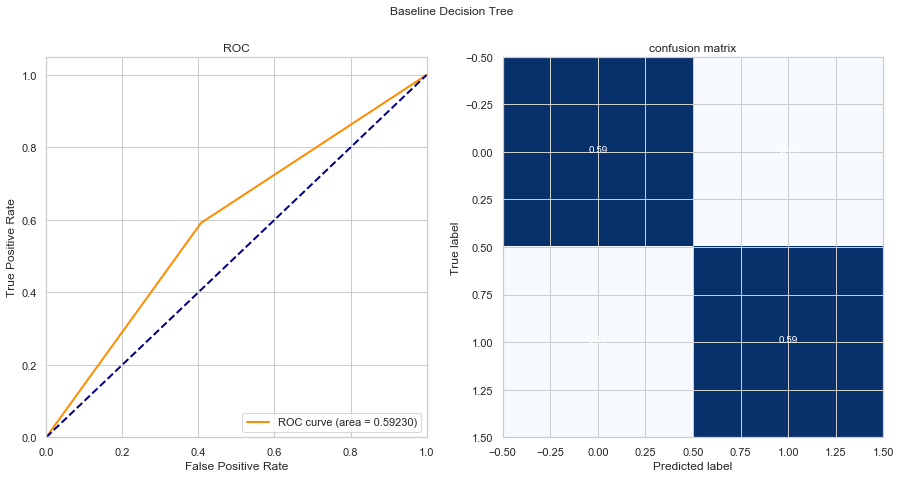

In [6]:
dt_base = DecisionTreeClassifier(max_depth = None)
dt_base.fit(X_train, y_train)

base_p = plot2graphs(dt_base, "Baseline Decision Tree")
print('Total Number of Predictors is %d' %np.sum(dt_base.feature_importances_ > 0))

### Decision Tree: Depth optimized

/Users/Grace/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


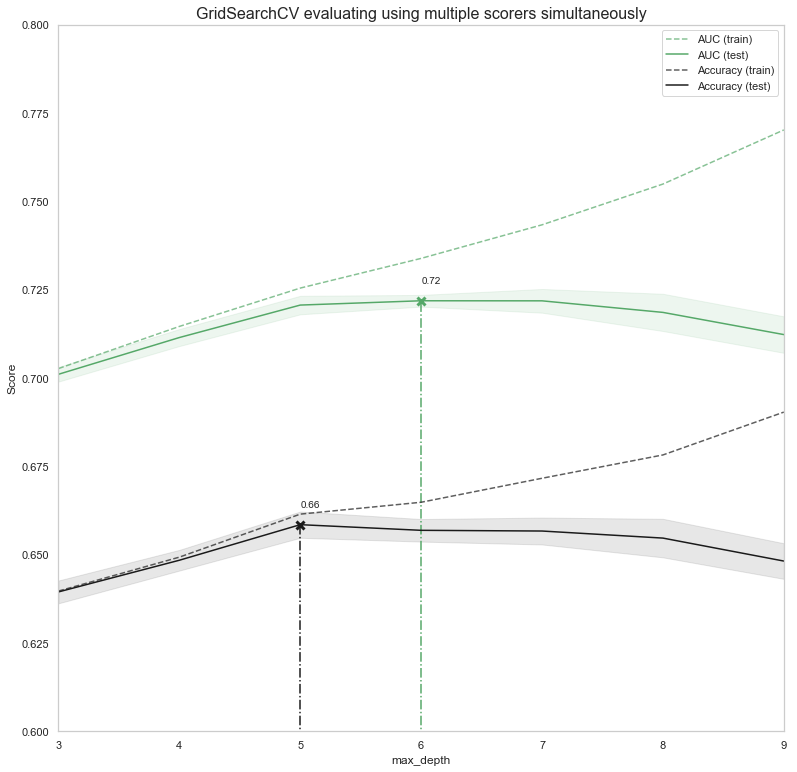

In [7]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'max_depth': range(3, 10)},
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
gs.fit(X_train, y_train)
results = gs.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("max_depth")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(3, 9)
ax.set_ylim(0.60, 0.80)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

Total Number of Predictors is 14


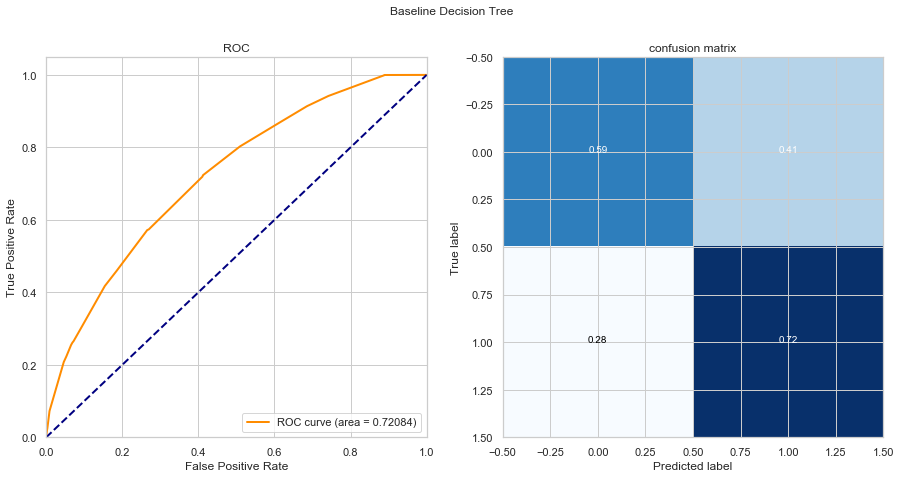

In [8]:
# fit decision tree with depth=6
dt_opt = DecisionTreeClassifier(max_depth = 6)
dt_opt.fit(X_train, y_train)
dt_opt_p = plot2graphs(dt_opt, "Baseline Decision Tree")
print('Total Number of Predictors is %d' %np.sum(dt_opt.feature_importances_ > 0))

### Random Forest: Grid Search for max_depth and n_estimators

In [53]:
grid = [{'n_estimators': [50, 100], 'max_depth': [10, 20]}] 
uni_scorer_selector(RandomForestClassifier(random_state=42), grid, sco = "roc_auc")

Best scoring: 0.744 (+/-0.006) for {'max_depth': 10, 'n_estimators': 100}


Total Number of Predictors is 76


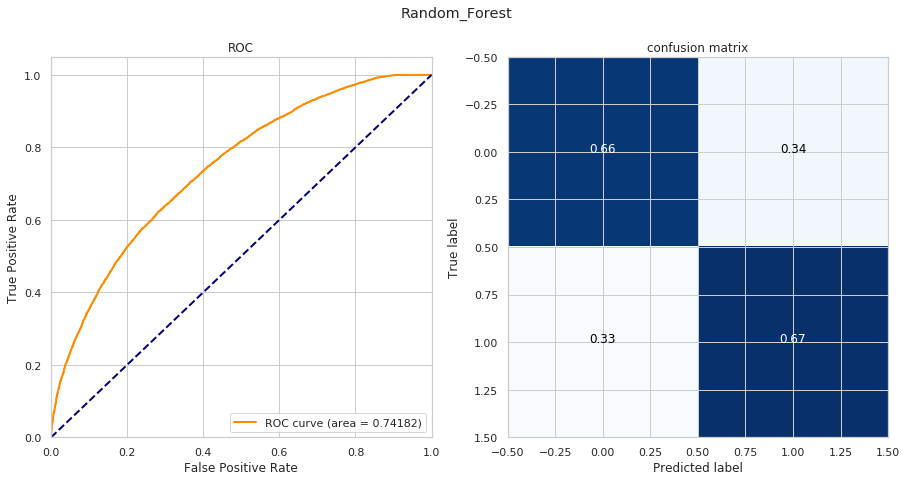

In [121]:
rf_opt = RandomForestClassifier(max_depth = 10, n_estimators=100).fit(X_train, y_train)
rf_opt_p = plot2graphs(rf_opt, "Random_Forest")
print('Total Number of Predictors is %d' %np.sum(rf_opt.feature_importances_ > 0))

### Losgistic Regression with L2 regularization

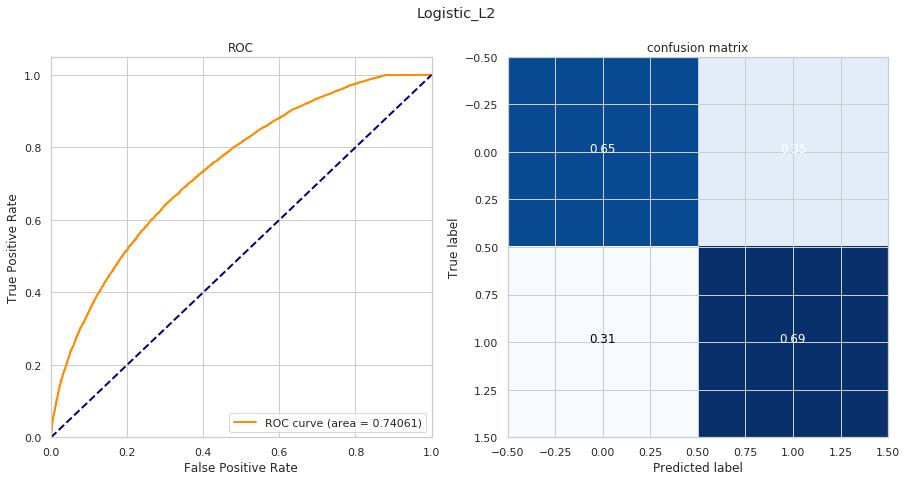

In [120]:
logreg = LogisticRegressionCV(penalty='l2',cv = 5, max_iter = 1000).fit(X_train,y_train)
logreg_p = plot2graphs(logreg, "Logistic_L2")

### Adaboost Classifier: Grid search on learning rate and n_estimators

In [73]:
grid = [{'n_estimators': [50, 100], 'learning_rate': [0.5,1]}] 
uni_scorer_selector(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2)), grid, sco = "roc_auc")

Best scoring: 0.688 (+/-0.013) for {'learning_rate': 0.5, 'n_estimators': 50}


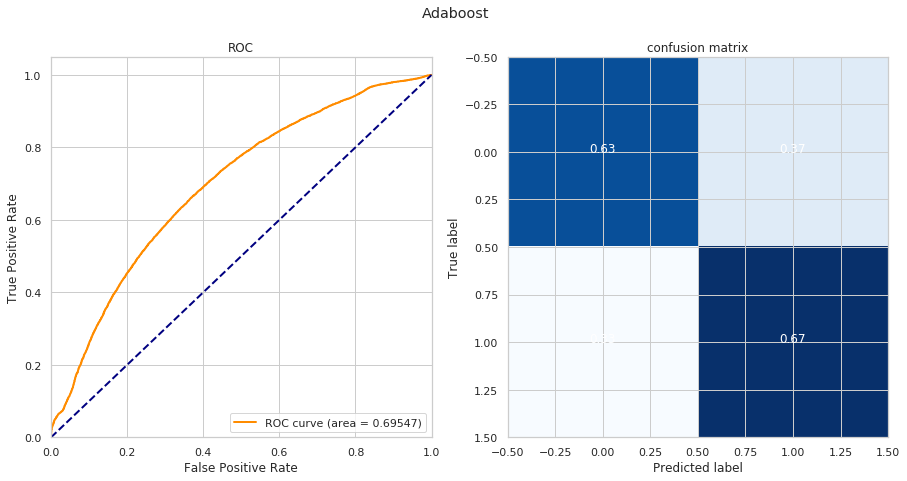

In [119]:
ada_opt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 6), learning_rate=0.5, n_estimators=50).fit(X_train, y_train)
ada_opt_p = plot2graphs(ada_opt, "Adaboost")
#print('Total Number of Predictors is %d' %np.sum(ada_opt.feature_importances_ > 0))
#fimp_rf = ada_opt.feature_importances_

### LDA, QDA: default setting

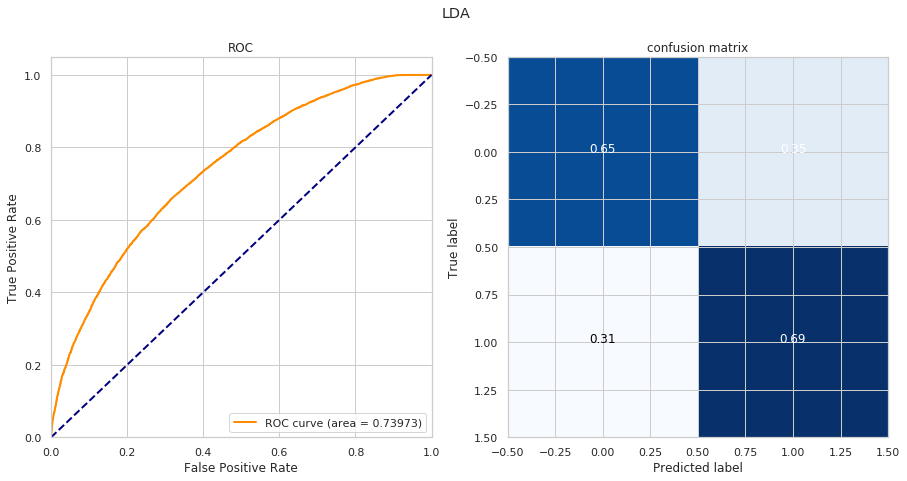

In [118]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)
lda_p = plot2graphs(lda_model, "LDA")

/home/qingzhang/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


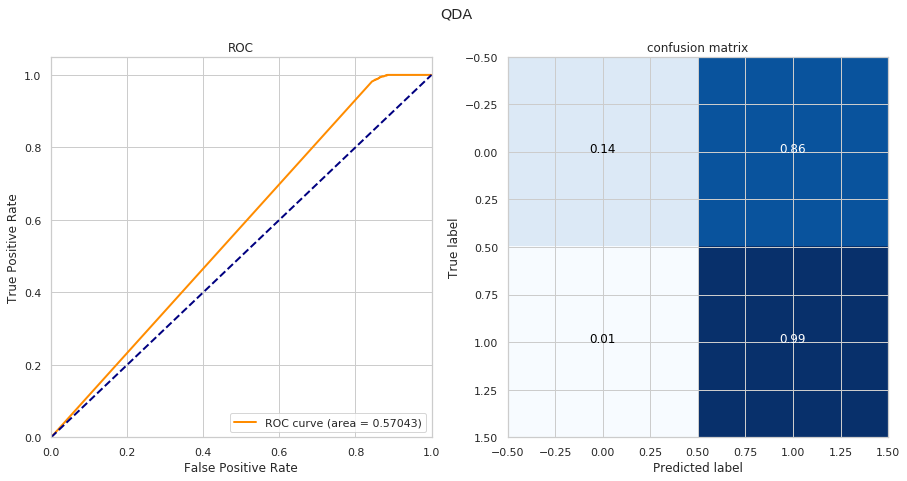

In [117]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_p = plot2graphs(qda_model, "QDA")

## Summary

### Featrue importances

In [94]:
fnames =df_train.drop("loan_status", axis=1).columns.tolist()

/home/qingzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/home/qingzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/qingzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


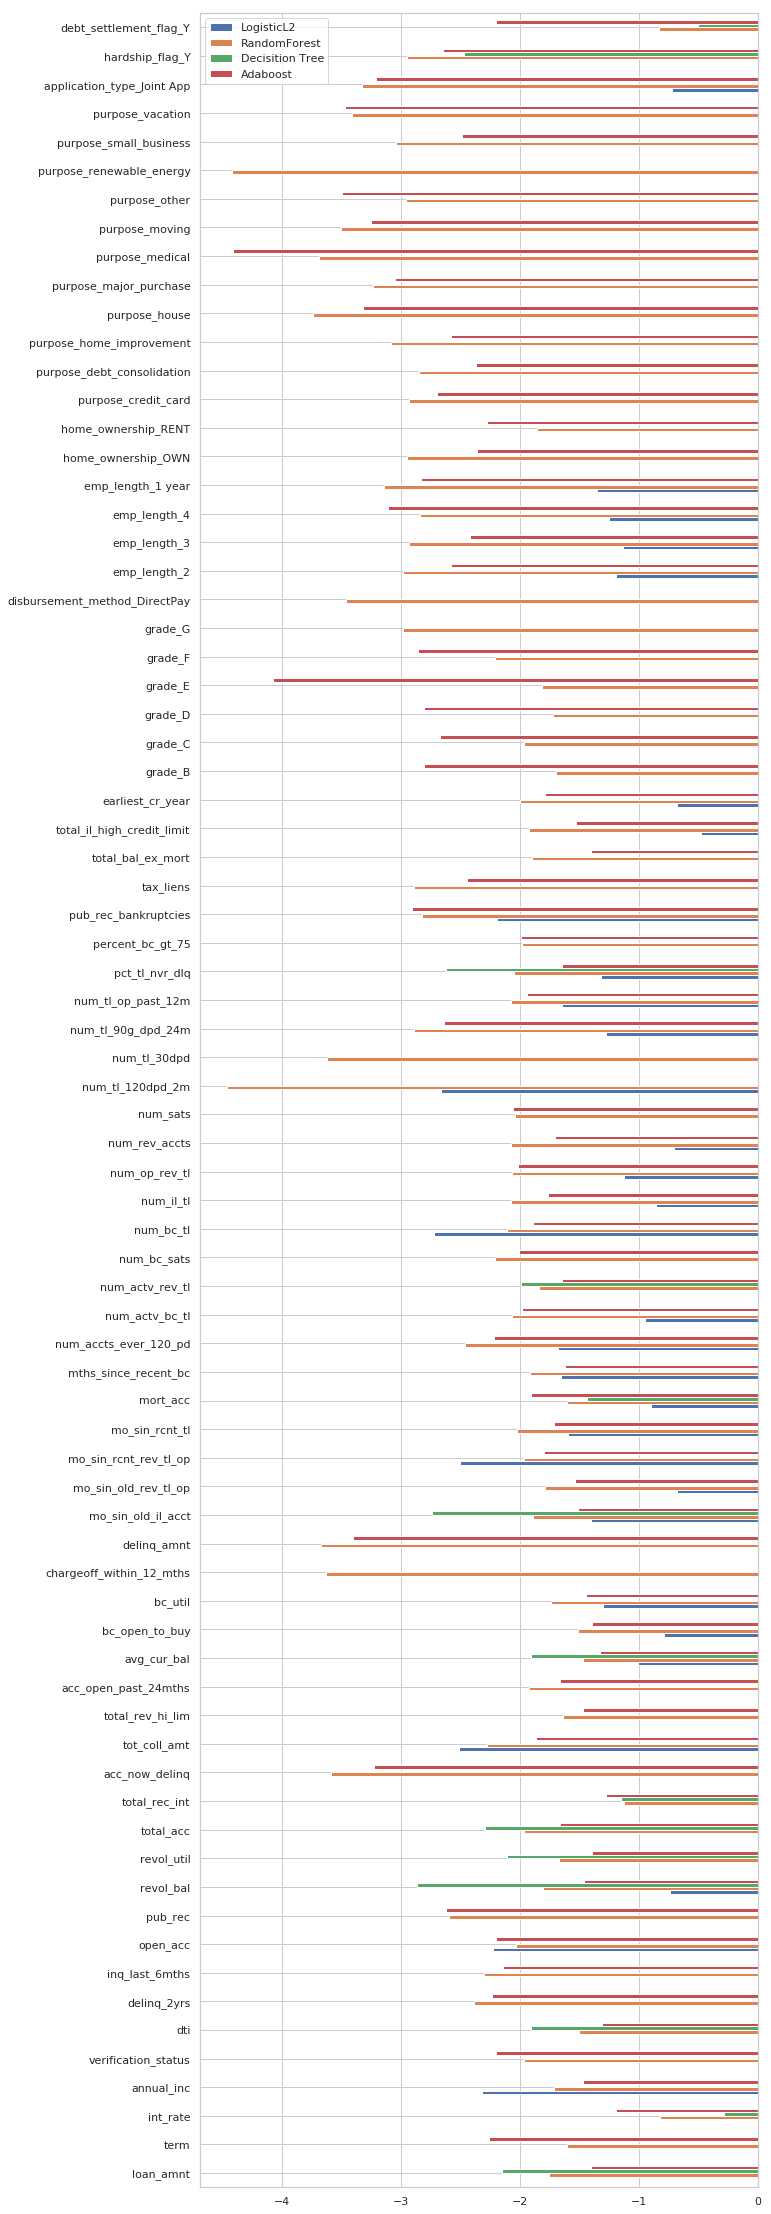

In [96]:
fimp_logreg = logreg.coef_.ravel()
fimp_rf = rf_opt.feature_importances_
fimp_dtopt = dt_opt.feature_importances_
fimp_ada = ada_opt.feature_importances_
pd.DataFrame({
    "LogisticL2":np.log10(fimp_logreg + 0.000001),
    "RandomForest":np.log10(fimp_rf),
    "Decisition Tree":np.log10(fimp_dtopt),
    "Adaboost":np.log10(fimp_ada)
}, index = fnames).plot.barh(figsize = (10,40))

### Performance measures

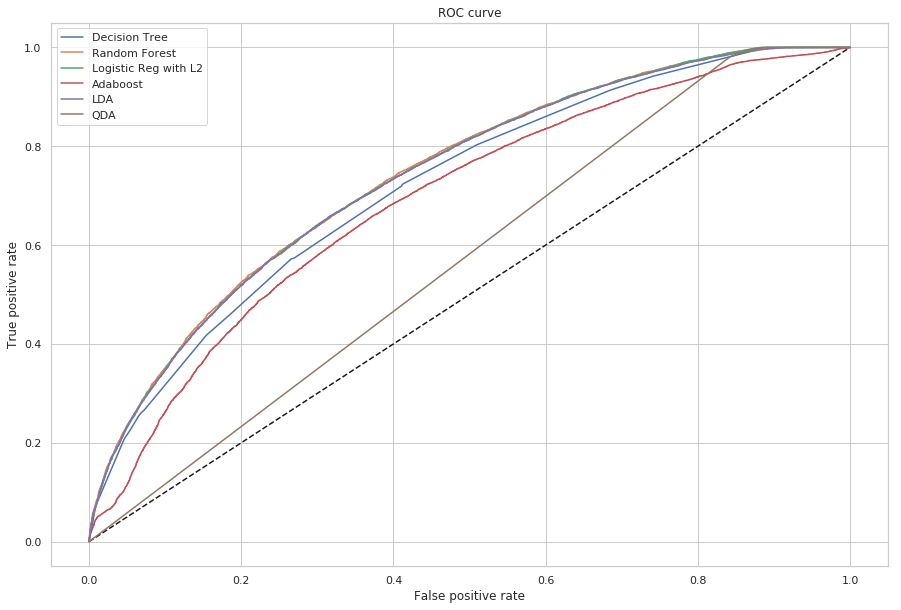

In [110]:
plt.figure(1, figsize = [15,10])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(dt_opt_p[1], dt_opt_p[2], label='Decision Tree')
plt.plot(rf_opt_p[1], rf_opt_p[2], label='Random Forest')
plt.plot(logreg_p[1], logreg_p[2], label='Logistic Reg with L2')
plt.plot(ada_opt_p[1], ada_opt_p[2], label='Adaboost')
plt.plot(lda_p[1], lda_p[2], label='LDA')
plt.plot(qda_p[1], qda_p[2], label='QDA')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [112]:
plist = []
for i in [ dt_opt_p, rf_opt_p, logreg_p, ada_opt_p, lda_p, qda_p]:
    plist.append(i[0])

In [123]:
pd.DataFrame(plist,
                columns=["sensitivity", "specificity", "accuracy", "auc_score"],
               index = ["Decision Tree", "RandomForest", "Logistic","Adaboost", "LDA", "QDA"])

,sensitivity,specificity,accuracy,auc_score
Decision Tree,0.679658,0.637069,0.655500,0.720962
RandomForest,0.671130,0.668032,0.669567,0.742228
Logistic,0.676587,0.663330,0.669700,0.740613
Adaboost,0.647788,0.638512,0.643000,0.690837
LDA,0.676270,0.662060,0.668867,0.739732
QDA,0.930898,0.535307,0.565267,0.570428


### Model stacking

In [ ]:
df = pd.concat([dt_opt_p[3], rf_opt_p[3], logreg_p[3], ada_opt_p[3], lda_p[3], qda_p[3]], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)

model = LogisticRegression(random_state=1)
model.fit(df,y_train)
model.score(df_test, y_test)